In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
import warnings
from itertools import product
from datetime import datetime, timedelta
import calendar

warnings.filterwarnings('ignore')
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
#加载数据
df = pd.read_csv(r"C:\Users\zhanghangbo\Desktop\数据挖掘算法\第八周\L8-code\L8\stock\000001.csv")
#数据探索
df = df[['Timestamp', 'Price']]



In [14]:
#让时间作为索引
# df = df.set_index(df.Timestamp)
# df.index
df.Timestamp = pd.to_datetime(df.Timestamp)
df.index = df.Timestamp


In [15]:
# 数据探索
print(df.head())
# 按照月，季度，年来统计
#按天来统计
df_day = df.resample("B")

df_month = df.resample('M').mean()
df_Q = df.resample('Q-DEC').mean()
df_year = df.resample('A-DEC').mean()
print(df_month)

            Timestamp   Price
Timestamp                    
1990-12-19 1990-12-19   99.98
1990-12-20 1990-12-20  104.39
1990-12-21 1990-12-21  109.13
1990-12-24 1990-12-24  114.55
1990-12-25 1990-12-25  120.25
                  Price
Timestamp              
1990-12-31   116.990000
1991-01-31   132.628182
1991-02-28   131.887778
1991-03-31   126.011429
1991-04-30   118.426818
...                 ...
2020-06-30  2940.737905
2020-07-31  3288.827239
2020-08-31  3374.214376
2020-09-30  3288.863209
2020-10-31  3333.268483

[359 rows x 1 columns]


In [16]:
# 设置参数范围
ps = range(0, 5)
qs = range(0, 5)
ds = range(1, 2)
parameters = product(ps, ds, qs)
parameters_list = list(parameters)
# 寻找最优ARMA模型参数，即best_aic最小
results = []
best_aic = float("inf") # 正无穷
for param in parameters_list:
    try:
        #训练模型
        model = sm.tsa.statespace.SARIMAX(df_month.Price,
                                order=(param[0], param[1], param[2]),
                                enforce_stationarity=False,
                                enforce_invertibility=False).fit()

    except ValueError:
        print('参数错误:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
# 输出最优模型
print('最优模型: ', best_model.summary())

最优模型:                                 SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                  359
Model:               SARIMAX(4, 1, 4)   Log Likelihood               -2290.593
Date:                Wed, 21 Oct 2020   AIC                           4599.187
Time:                        22:12:33   BIC                           4633.985
Sample:                    12-31-1990   HQIC                          4613.033
                         - 10-31-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1731      0.151      7.757      0.000       0.877       1.469
ar.L2         -0.2101      0.283     -0.743      0.457      -0.764       0.344
ar.L3          0.0483      0.267      0.181  

In [17]:
# 设置future_month，需要预测的时间date_list
df_month2 = df_month[['Price']]
#数据集截至时间为2020-10-16，预测两个月11月份和12月份得大盘走势
future_month = 2
last_month = pd.to_datetime(df_month2.index[len(df_month2)-1])
date_list = []
for i in range(future_month):
    # 计算下个月有多少天
    year = last_month.year
    month = last_month.month
    if month == 12:
        month = 1
        year += 1
    else:
        month += 1
    next_month_days = calendar.monthrange(year, month)[1]
    print(next_month_days)
    last_month = last_month + timedelta(days=next_month_days)
    date_list.append(last_month)
print('date_list=', date_list)

30
31
date_list= [Timestamp('2020-11-30 00:00:00', freq='M'), Timestamp('2020-12-31 00:00:00', freq='M')]


In [18]:
# 添加未来要预测的2个月
future = pd.DataFrame(index=date_list, columns= df_month.columns)
# print(future)
df_month2 = pd.concat([df_month2, future])
print(df_month2)
# get_prediction得到的是区间，使用predicted_mean
df_month2['forecast'] = best_model.get_prediction(start=0, end=len(df_month2)).predicted_mean

                  Price
1990-12-31   116.990000
1991-01-31   132.628182
1991-02-28   131.887778
1991-03-31   126.011429
1991-04-30   118.426818
...                 ...
2020-08-31  3374.214376
2020-09-30  3288.863209
2020-10-31  3333.268483
2020-11-30          NaN
2020-12-31          NaN

[361 rows x 1 columns]


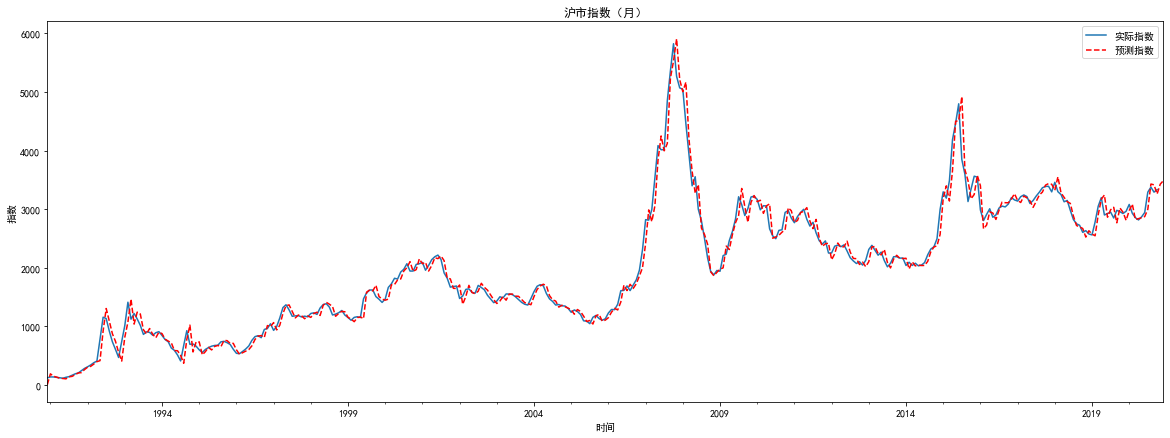

In [20]:

# 沪市指数预测结果显示
plt.figure(figsize=(20,7))
df_month2.Price.plot(label='实际指数')
df_month2.forecast.plot(color='r', ls='--', label='预测指数')
plt.legend()
plt.title('沪市指数（月）')
plt.xlabel('时间')
plt.ylabel('指数')
plt.show()

#thinking1
今天讲解了时间序列预测的两种方式，实际上在数据库内建时间属性后，可以产生时序数据库，请思考什么是时序数据库？为什么时间序列数据成为增长最快的数据类型之一
时序数据库叫时间序列数据库，主要处理带时间标签得数据，该数据在时间上分布得一系列值。有很多得业务场景都会带有时间的数据，如股票价格，时间随温度得变化等等，所以也会有很多的场景用到时间序列数据库。


#thinking2 BCG Matrix（波士顿矩阵）四象限分别代表什么？不同象限，有怎样的数据决策
代表了1.明星类产品，销售增长率和市场占有率双高的产品群
2.瘦狗类产品，销售增长率和市场占有率双低的产品群
3.问题类产品，销售增长率高，市场占有率低的产品群
4.金牛类产品，销售增长率低，市场占有率高的产品群